<>:413: SyntaxWarning: invalid escape sequence '\m'
<>:413: SyntaxWarning: invalid escape sequence '\s'
<>:471: SyntaxWarning: invalid escape sequence '\m'
<>:471: SyntaxWarning: invalid escape sequence '\s'
<>:413: SyntaxWarning: invalid escape sequence '\m'
<>:413: SyntaxWarning: invalid escape sequence '\s'
<>:471: SyntaxWarning: invalid escape sequence '\m'
<>:471: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ah5021\AppData\Local\Temp\ipykernel_4836\265966316.py:413: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, pdf, 'r-', label=f'Normal fit\n$\mu={mu_v_seq:.2f}$, $\sigma={std_v_seq:.2f}$')
C:\Users\ah5021\AppData\Local\Temp\ipykernel_4836\265966316.py:413: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, pdf, 'r-', label=f'Normal fit\n$\mu={mu_v_seq:.2f}$, $\sigma={std_v_seq:.2f}$')
C:\Users\ah5021\AppData\Local\Temp\ipykernel_4836\265966316.py:471: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, pdf, 'r-', label=f'Normal fit\n$\mu={mu_a_seq:


DATA AUGMENTATION CONFIGURATION
Input file: autosave_capture.csv
Dataset filter: E03A101_PROT/LLN0$DS_GENERAL_TRIP
Output file: augmented_data.csv
Target duration: 1110.0 hours (46.2 days)
Attack percentage target: 40%

Starting analysis of original data to augment...
Loading file...
✓ Loaded 43,099 total rows

Filtering for dataset: E03A101_PROT/LLN0$DS_GENERAL_TRIP
✓ Found 6,608 rows for E03A101_PROT/LLN0$DS_GENERAL_TRIP

Dropping column 'datSet' after filtering

Analyzing data patterns...
✓ Found 17 unique states: [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39].

Detailed State Analysis:
  State 23: 200 messages, seq range 89492-89691 (sqNum=0 present: False)
  State 24: 147 messages, seq range 0-95 (sqNum=0 present: True)
  State 25: 410 messages, seq range 0-269 (sqNum=0 present: True)
  State 26: 32 messages, seq range 0-31 (sqNum=0 present: True)
  State 27: 366 messages, seq range 0-365 (sqNum=0 present: True)
  State 28: 156 messages, seq range 0-155 (sqN

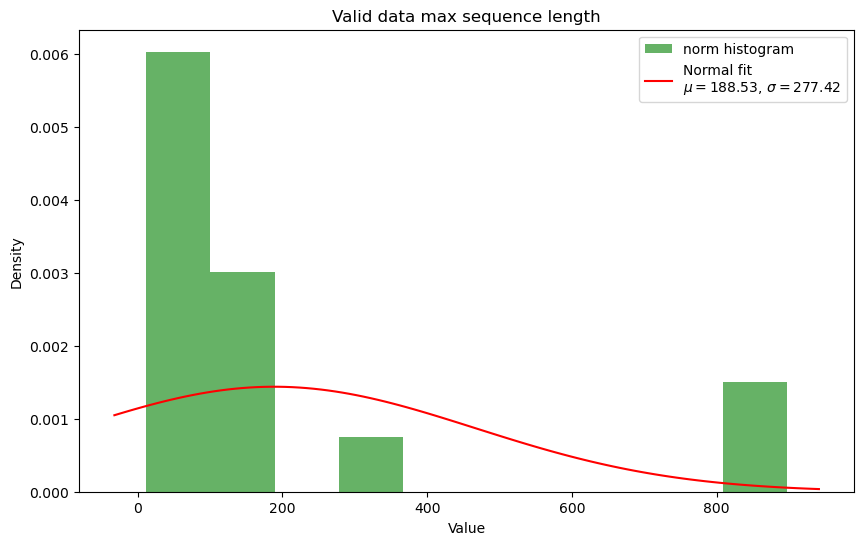


Starting calculation of attack message speed...
✓ Average attack message speed is 3833462432 nanoseconds


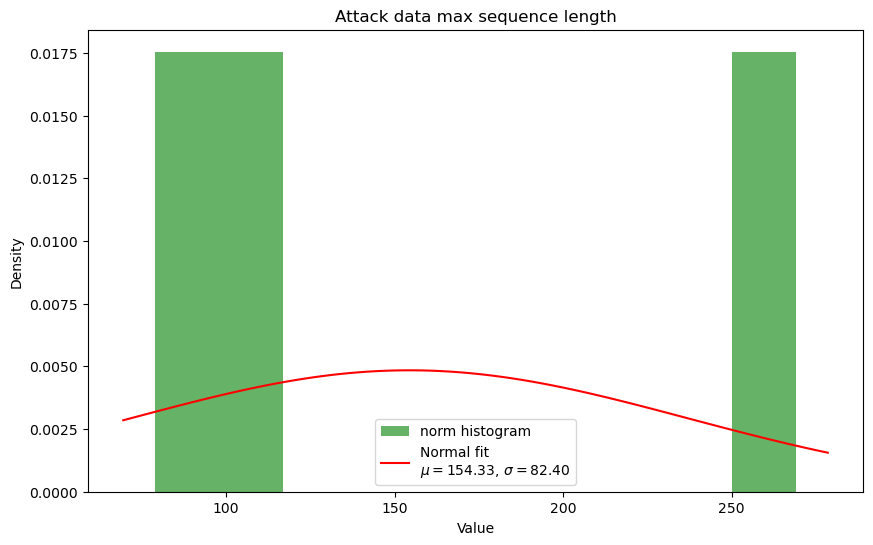


✓ Feature extraction of original data complete.
Message speed: 4971052631 nanoseconds
Message burst speed: [numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(90909090,'ns'), numpy.timedelta64(750000000,'ns'), numpy.timedelta64(1000000000,'ns'), numpy.timedelta64(1875000000,'ns'), numpy.timedelta64(3642857142,'ns')]
Attack message speed: 3833462432 nanoseconds
Distribution of max message sequence length: mean 188.53333333333333, std 277.4185446016342
Distribution of max attack message sequence length: mean 154.33333333333334, std 82.40280469876146

DATA AUGMENTATION PHASE
Phase 1/4: Generating legitimate data...
Phase 2/4: Creating attack blocks...
Phase 3/4: Inserting attack data...

In [ ]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, truncnorm
import random
import bisect
import os

def augment_data():
    
    # EDITABLES
    file_path="dataset/autosave_capture.csv"
    dataset_filter="E03A101_PROT/LLN0$DS_GENERAL_TRIP"
    output_file="dataset/augmented_data.csv"
    # percentage of attack(states) to aim for in the data augmentation
    p_attack = 0.4
    # hour to which the dataset should be expanded to
    augment_hour = np.timedelta64(1110 * 60 * 60 * 1000, 'ms')
    # timezone in utcTime
    timezone = ' UTC'

    # Print configuration summary
    print("\n" + "="*50)
    print("DATA AUGMENTATION CONFIGURATION")
    print("="*50)
    print(f"Input file: {file_path}")
    print(f"Dataset filter: {dataset_filter}")
    print(f"Output file: {output_file}")
    print(f"Target duration: {augment_hour / np.timedelta64(1, 'h')} hours ({augment_hour / np.timedelta64(24, 'h'):.1f} days)")
    print(f"Attack percentage target: {p_attack*100:.0f}%")
    print("="*50)

    # Analyse input data
    # Use G_Analyzer to detect injections
    print("\nStarting analysis of original data to augment...")
    
    # Check if input file exists
    if not os.path.exists(file_path):
        print(f"✗ Error: Input file '{file_path}' not found in current directory: {os.getcwd()}")
        print(f"Please ensure the file exists in the current directory.")
        return
    
    # Load only necessary columns for speed
    print("Loading file...")
    try:
        df = pd.read_csv(file_path, usecols=['allData', 'datSet', 'stNum', 'sqNum', 'timestamp', 'utcTime']) 
        print(f"✓ Loaded {len(df):,} total rows")
    except FileNotFoundError:
        print(f"✗ Error: File '{file_path}' not found!")
        return
    except KeyError as e:
        print(f"✗ Error: Required columns not found in CSV. Missing: {e}")
        print(f"Available columns: {list(pd.read_csv(file_path, nrows=1).columns)}")
        return
    except Exception as e:
        print(f"✗ Error loading file: {e}")
        return

    # Filter for target dataset
    print(f"\nFiltering for dataset: {dataset_filter}")
    filtered_df = df[df['datSet'] == dataset_filter].copy()
    print(f"✓ Found {len(filtered_df):,} rows for {dataset_filter}")
    
    if len(filtered_df) == 0:
        print(f"✗ No data found for {dataset_filter} dataset!")
        print(f"Available datasets in the file:")
        for ds in df['datSet'].unique():
            print(f"  - {ds}")
        return
    
    # Reset the old indexing
    filtered_df.reset_index(drop=True, inplace=True)
    
    # column datSet not needed anymore after filtering
    print("\nDropping column 'datSet' after filtering")
    filtered_df = filtered_df.drop(['datSet'], axis=1)

    # Ensure stNum and sqNum are of integer type
    filtered_df['stNum'] = pd.to_numeric(filtered_df['stNum'], errors='coerce').fillna(-1).astype(int)
    filtered_df['sqNum'] = pd.to_numeric(filtered_df['sqNum'], errors='coerce').fillna(-1).astype(int)

    # Remove any rows where conversion failed (stNum or sqNum became -1)
    initial_rows = len(filtered_df)
    filtered_df = filtered_df[(filtered_df['stNum'] != -1) & (filtered_df['sqNum'] != -1)]
    if len(filtered_df) < initial_rows:
        print(f"✓ Removed {initial_rows - len(filtered_df)} rows due to invalid stNum/sqNum after conversion.")
    
    # create column label for labeling attack and legitimate messages
    filtered_df.insert(0, 'label', int(-1))

    # Convert to numpy arrays for slightly faster access in loops
    states_arr = filtered_df['stNum'].values
    sequences_arr = filtered_df['sqNum'].values

    # Analyze the data
    print("\nAnalyzing data patterns...")
    
    # Get unique states and their info (still useful for overall context)
    unique_states = np.unique(states_arr)
    print(f"✓ Found {len(unique_states)} unique states: {sorted(list(unique_states))}.")

    state_info = {} # To store overall stats for each state
    print("\nDetailed State Analysis:")
    for state in unique_states:
        state_mask = states_arr == state
        state_seqs = sequences_arr[state_mask]
        
        if len(state_seqs) > 0:
            state_info[state] = {
                'count': len(state_seqs),
                'min_seq': state_seqs.min(),
                'max_seq': state_seqs.max(),
                'has_sqnum_zero': any(state_seqs == 0)
            }
            print(f"  State {state}: {state_info[state]['count']} messages, seq range {state_info[state]['min_seq']}-{state_info[state]['max_seq']}"
                  f" (sqNum=0 present: {state_info[state]['has_sqnum_zero']})")
        else:
            state_info[state] = { 
                'count': 0, 'min_seq': -1, 'max_seq': -1, 'has_sqnum_zero': False
            }
            print(f"  State {state}: No valid messages after filtering.")

    # --- ENHANCED INJECTION DETECTION LOGIC ---
    print("\n" + "="*50)
    print("ENHANCED INJECTION DETECTION (Focus on Inconsistency):")
    print("Looking for sqNum resets from an 'injected' state, while another 'legitimate' state continues its progression.")
    print("="*50)
    
    # Use a set to store unique injection scenarios: (injected_state, legitimate_state)
    detected_injection_scenarios = set() 
    
    # A dictionary to store details about each detected event
    detected_injection_events = []

    # Define a window to look for legitimate traffic around an sqNum=0 event
    LOOK_WINDOW_SIZE = 10 # Number of messages to look before and after

    # Iterate through the DataFrame to find sqNum resets
    for i in range(len(filtered_df)):
        current_st_num = states_arr[i]
        current_sq_num = sequences_arr[i]
        
        # Condition 1: Check for sqNum reset to 0
        if current_sq_num == 0:
            potential_injected_state = current_st_num
            
            # Reset for this event
            legitimate_state_id = -1
            legit_state_example_seq = -1
            
            best_legit_candidate = None # To store (state_id, max_sq_in_window)
            
            window_start = max(0, i - LOOK_WINDOW_SIZE)
            window_end = min(len(filtered_df), i + LOOK_WINDOW_SIZE + 1)
            
            # First pass: collect all states and their sequences in the window
            window_states_data = {} # {state_id: [sq1, sq2, ...]}
            for k in range(window_start, window_end):
                st = states_arr[k]
                sq = sequences_arr[k]
                if st not in window_states_data:
                    window_states_data[st] = []
                window_states_data[st].append(sq)

            # Second pass: evaluate legitimate candidates based on consistency
            for candidate_legit_state in window_states_data.keys():
                if candidate_legit_state == potential_injected_state:
                    continue # Skip the injected state itself
                
                candidate_seqs = window_states_data[candidate_legit_state]
                
                # Check for presence before and after the injected message
                is_present_before = False
                for k_before in range(max(0, i - LOOK_WINDOW_SIZE), i):
                    if states_arr[k_before] == candidate_legit_state:
                        is_present_before = True
                        break
                
                is_present_after = False
                for k_after in range(i + 1, min(len(filtered_df), i + LOOK_WINDOW_SIZE + 1)):
                    if states_arr[k_after] == candidate_legit_state:
                        is_present_after = True
                        break

                if is_present_before and is_present_after:
                    min_sq_in_window = min(candidate_seqs)
                    max_sq_in_window = max(candidate_seqs)

                    # Criteria for a "legitimate" state in this specific attack context:
                    # 1. It appears both before AND after the current_st_num=0 event.
                    # 2. Its sequence numbers *in this window* are generally high and don't include 0.
                    #    Using min_sq_in_window > 5 helps filter out candidates that are also just restarting.
                    
                    if min_sq_in_window > 5: # Threshold to ensure it's progressing, not restarting itself
                        # This candidate is valid. Now, check if it's the "best" one.
                        if best_legit_candidate is None or max_sq_in_window > best_legit_candidate[1]:
                            best_legit_candidate = (candidate_legit_state, max_sq_in_window, min_sq_in_window) # Store (id, max_sq, min_sq)
            
            # If a best legitimate candidate was found
            if best_legit_candidate:
                legitimate_state_id = best_legit_candidate[0]
                legit_state_example_seq = best_legit_candidate[2] # Use min_sq_in_window for example print
                
                scenario_tuple = (potential_injected_state, legitimate_state_id)
                
                if scenario_tuple not in detected_injection_scenarios:
                    detected_injection_scenarios.add(scenario_tuple)
                    
                    detected_injection_events.append({
                        'event_row': i,
                        'injected_state': int(potential_injected_state),
                        'injected_sqnum': int(current_sq_num),
                        'legitimate_state_context': int(legitimate_state_id),
                        'legit_state_example_sqnum': int(legit_state_example_seq)
                    })

                    print(f"\n🚨 INJECTION SCENARIO DETECTED! 🚨 (Event at row {i})")
                    print(f"  • Injected State (likely): {potential_injected_state} (sqNum reset to {current_sq_num})")
                    print(f"  • Legitimate State (nearby and progressing): {legitimate_state_id} (seen with sqNum like {legit_state_example_seq}+)")
                    
                    print(f"\nExample of sequence around row {i} (window size {LOOK_WINDOW_SIZE}):")
                    start_idx = max(0, i - LOOK_WINDOW_SIZE // 2)
                    end_idx = min(len(filtered_df), i + LOOK_WINDOW_SIZE // 2 + 1)

                    # flag injection as attack, 1
                    # set max counter to when the attack is finished
                    counter = 0
                    expected_sq = -1
                    overlap = False
                    # check if an attack overlaps closely with a valid trip
                    # then we use a slower algorithm to flag
                    for j in range(i+1, min(i+20, len(filtered_df))):
                            if states_arr[j] == int(potential_injected_state) and sequences_arr[j] == int(current_sq_num):
                                overlap = True
                    if overlap == False:
                        for k in range (i, len(filtered_df)):
                            if k == i:
                                filtered_df.loc[k, 'label'] = 1
                                expected_sq = int(current_sq_num) + 1
                            elif counter > 20:
                                break
                            elif states_arr[k] == int(potential_injected_state) and sequences_arr[k] == expected_sq:
                                filtered_df.loc[k, 'label'] = 1
                                expected_sq += 1
                                counter = 0
                            else:
                                counter += 1
                    elif overlap == True:
                        for k in range (i, len(filtered_df)):
                            if k == i:
                                filtered_df.loc[k, 'label'] = 1
                                expected_sq = int(current_sq_num) + 1
                            elif states_arr[k] == int(potential_injected_state) and sequences_arr[k] == expected_sq:
                                k_min = min(k+1, len(filtered_df)-1)
                                k_max = min(k+20, len(filtered_df)-1)
                                # track if we find a duplicate in vicinity, which means both attack and valid msg is getting send
                                match_found = False
                                for a, b in zip (states_arr[k_min:k_max], sequences_arr[k_min:k_max]):
                                    if (a, b) == (int(potential_injected_state), expected_sq):
                                        filtered_df.loc[k, 'label'] = 1
                                        expected_sq += 1
                                        match_found = True
                                        break
                                # no more duplicates == attack has ended
                                if not match_found:
                                    break

    # flag all unflagged previous data as legitimate, 0
    for k in range (0, len(filtered_df)):
        if filtered_df.loc[k,'label'] == -1:
            filtered_df.loc[k,'label'] = 0

    print("\n✓ Labeling of original data complete.")
    # extract features needed for data augmentation
    print("\nStarting extracting features for data augmentation...")

    # Initialize features to extract
    # all speed in ms
    # normal distribution

    # Valid message speed
    msg_spd = -1
    # Message burst
    msg_burst_spd = []
    # Attack message speed
    attack_msg_speed = -1
    # Distribution of max sequence length for valid messages
    mu_v_seq, std_v_seq = -1, -1
    # Distribution of max sequence length for attack messages
    mu_a_seq, std_a_seq = -1, -1
    
    
    # Convert timestamp from string to datetime
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    # Convert utcTime from string to datetime
    if timezone:
        filtered_df['utcTime'] = filtered_df['utcTime'].str.replace(timezone, '', regex=False)
    # pd datetime only supports up to 9 digits
    filtered_df['utcTime'] = filtered_df['utcTime'].str.replace(r'(\.\d{9})\d*', r'\1', regex=True)
    filtered_df['utcTime'] = pd.to_datetime(filtered_df['utcTime'], format="%b %d, %Y %H:%M:%S.%f")
    

    # Filter for legitimate messages
    legit_df = filtered_df[filtered_df['label'] == 0].copy()
    print(f"✓ Found {len(legit_df):,} rows for legitimate messages")
    # Reset the old indexing
    legit_df.reset_index(drop=True, inplace=True)

    # Filter for attack messages
    attack_df = filtered_df[filtered_df['label'] == 1].copy()
    print(f"✓ Found {len(attack_df):,} rows for attack messages")

    # Check if we have enough data to proceed
    if len(legit_df) < 10:
        print(f"✗ Not enough legitimate data to extract features (only {len(legit_df)} rows)")
        return
    
    if len(attack_df) < 10:
        print(f"⚠ Warning: Very few attack messages detected ({len(attack_df)} rows)")

    # Convert to numpy arrays for slightly faster access in loops
    v_timestamp_arr = legit_df['timestamp'].values
    v_states_arr = legit_df['stNum'].values
    v_sequences_arr = legit_df['sqNum'].values

    print("\nStarting calculation of message burst speed...")

    # Calculate rough average message speed as breakpoint of message burst
    rough_msg_diff = np.timedelta64(v_timestamp_arr[len(legit_df)-1] - v_timestamp_arr[0] ,'ns')
    rough_msg_speed = rough_msg_diff/len(legit_df)

    # Compute how many maximum messages were sent in the exact same second
    # Index of state changes in legitimate messages
    new_event = np.where(v_sequences_arr == 0)[0]
    same_sec = 1
    for i in new_event:
        start_ts = v_timestamp_arr[i]
        j = i+1
        expected_seq = 1
        while j < len(legit_df) and v_timestamp_arr[j] == start_ts and v_sequences_arr[j] == expected_seq:
            j += 1
            expected_seq += 1
        same_sec = max(same_sec, (j-i))
    msg_burst = [np.timedelta64(1000000000,'ns')/same_sec] * same_sec

    # Compute tail behaviour
    tail = []
    for i in new_event:
        j = i + same_sec - 1
        pos = 0
        # -1 cause we need to calculate the difference between the last same second msg and the next msg (beginning of tail)
        expected_seq = same_sec - 1
        while j+1 < len(legit_df) and v_sequences_arr[j] == expected_seq and np.timedelta64(v_timestamp_arr[j+1] - v_timestamp_arr[j] ,'ns') < rough_msg_speed:
            dif = np.timedelta64(v_timestamp_arr[j+1] - v_timestamp_arr[j] ,'ns')
            if pos >= len(tail):
                tail.append([])  # add new inner list
            tail[pos].append(dif)
            pos += 1
            j += 1
            expected_seq += 1
    # Tail list
    avg_per_inner_list = [np.mean(inner_list) for inner_list in tail]
    
    # Complete message burst speed list
    msg_burst_speed = msg_burst + avg_per_inner_list
    print(f"✓ Message burst lasts for {len(msg_burst_speed)} messages.")

    # Calculate exact legitimate message speed outside of message burst
    last_event = 0
    msg_amount = 0
    dif = 0
    for i in new_event:
        msg_amount += i-last_event
        dif += np.timedelta64(v_timestamp_arr[i-1] - v_timestamp_arr[last_event] ,'ns')
        last_event = i+len(msg_burst_speed)
    if len(new_event) > 0:
        msg_amount += len(v_timestamp_arr)-1 - new_event[-1]
        dif += np.timedelta64(v_timestamp_arr[len(v_timestamp_arr)-1] - v_timestamp_arr[new_event[-1]] ,'ns')
        msg_speed = dif / msg_amount
        print(f"✓ Legitimate message speed is approximately {msg_speed}")
    else:
        print("⚠ Warning: No new events found in legitimate data")
        msg_speed = rough_msg_speed

    # Calculate approximating distribution for max sequence length
    max_sequence_length = []
    for i in new_event:
        if i > 0:  # Ensure we don't go out of bounds
            max_sequence_length.append(v_sequences_arr[i-1])
    
    # Drop the first sequence otherwise the distribution can get skewed
    # Precaution if the system was idle for long time and the sequence number is very high
    if len(max_sequence_length) > 1:
        max_sequence_length = max_sequence_length[1:]
    
    if len(max_sequence_length) > 0:
        # Fit a normal distribution to max_sequence_length get mean and std
        mu_v_seq, std_v_seq = norm.fit(max_sequence_length)
        
        # Plot histogram of the data (normalized to form a PDF)
        plt.figure(figsize=(10, 6))
        plt.hist(max_sequence_length, bins=10, density=True, alpha=0.6, color='g', label='norm histogram')
        
        # Generate x values for the PDF curve
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        
        # Compute the PDF of the fitted normal distribution
        pdf = norm.pdf(x, mu_v_seq, std_v_seq)
        
        # Plot the PDF curve
        plt.plot(x, pdf, 'r-', label=f'Normal fit\n$\mu={mu_v_seq:.2f}$, $\sigma={std_v_seq:.2f}$')
        
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Valid data max sequence length')
        plt.legend()
        plt.show()
    else:
        print("⚠ Warning: Not enough data to fit sequence length distribution")
        mu_v_seq, std_v_seq = 100, 20  # Default values

    print("\nStarting calculation of attack message speed...")

    if len(attack_df) > 0:
        # Convert to numpy arrays for slightly faster access in loops
        a_timestamp_arr = attack_df['timestamp'].values
        a_states_arr = attack_df['stNum'].values
        a_sequences_arr = attack_df['sqNum'].values

        # Calculate avgerage attack message speed
        # Get unique attack states to create attack blocks
        unique_attack_state = attack_df['stNum'].unique()
        attack_event = np.where(a_sequences_arr == 0)[0]
        start_end_event = np.append(attack_event[1:],(len(a_sequences_arr)))
        attack_start = 0
        attack_msg_diff = np.timedelta64(0, 'ns')
        for i in unique_attack_state:
            attack_block_df = attack_df[attack_df['stNum'] == i].copy()
            if len(attack_block_df) > 1:
                attack_msg_diff += np.timedelta64(attack_block_df['timestamp'].iloc[-1] - attack_block_df['timestamp'].iloc[0] ,'ns')
        if attack_msg_diff > 0:
            attack_msg_speed = attack_msg_diff/len(a_timestamp_arr)
        else:
            attack_msg_speed = msg_speed * 0.8  # Default to 80% of legitimate speed
        print(f"✓ Average attack message speed is {attack_msg_speed}")

        # Calculate the distribution of max attack sequence length
        max_attack_seq_length = []
        for i in attack_event:
            if i > 0:  # Ensure we don't go out of bounds
                max_attack_seq_length.append(a_sequences_arr[i-1])

        if len(max_attack_seq_length) > 0:
            # Fit a normal distribution to max_attack_seq_length get mean and std
            mu_a_seq, std_a_seq = norm.fit(max_attack_seq_length)

            # Plot histogram of the data (normalized to form a PDF)
            plt.figure(figsize=(10, 6))
            plt.hist(max_attack_seq_length, bins=10, density=True, alpha=0.6, color='g', label='norm histogram')
            
            # Generate x values for the PDF curve
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            
            # Compute the PDF of the fitted normal distribution
            pdf = norm.pdf(x, mu_a_seq, std_a_seq)
            
            # Plot the PDF curve
            plt.plot(x, pdf, 'r-', label=f'Normal fit\n$\mu={mu_a_seq:.2f}$, $\sigma={std_a_seq:.2f}$')
            
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.title('Attack data max sequence length')
            plt.legend()
            plt.show()
        else:
            print("⚠ Warning: Not enough attack data to fit sequence length distribution")
            mu_a_seq, std_a_seq = 50, 10  # Default values
    else:
        print("⚠ Warning: No attack data found, using default values")
        attack_msg_speed = msg_speed * 0.8
        mu_a_seq, std_a_seq = 50, 10

    print("\n" + "="*50)
    print("✓ Feature extraction of original data complete.")
    print(f"Message speed: {msg_speed}")
    print(f"Message burst speed: {msg_burst_speed}")
    print(f"Attack message speed: {attack_msg_speed}")
    print(f"Distribution of max message sequence length: mean {mu_v_seq}, std {std_v_seq}")
    print(f"Distribution of max attack message sequence length: mean {mu_a_seq}, std {std_a_seq}")
    print("="*50)
    
    print("\n" + "="*50)
    print("DATA AUGMENTATION PHASE")
    print("="*50)
    print("Phase 1/4: Generating legitimate data...")
    print("Phase 2/4: Creating attack blocks...")
    print("Phase 3/4: Inserting attack data...")
    print("Phase 4/4: Sorting and saving...")
    print("="*50)
    
    print("\nPhase 1/4: Starting data augmentation by expanding original data...")

    # Create valid data first
    # Get the two different allData into a list for easy access
    allData_list = filtered_df['allData'].unique().tolist()
    
    if len(allData_list) == 0:
        print("⚠ Warning: No allData values found in filtered data")
        return
    elif len(allData_list) == 1:
        print(f"⚠ Warning: Only one allData value found: {allData_list[0]}")
        # Duplicate it to avoid index errors
        allData_list = allData_list * 2

    # Get last valid message from original data to continue generating at the right location
    latest_valid_msg = filtered_df[filtered_df['label'] == 0].iloc[-1]
    current_utcTime = 0
    # Set mininum legit message max sequence length to length of message burst
    min_sequence = len(msg_burst_speed)
    lower_v, upper = min_sequence, np.inf
    a_v, b_v = (lower_v - mu_v_seq) / std_v_seq, (upper - mu_v_seq) / std_v_seq
    # Calculate max timestamp needed to reach the desired length/size of the augmented dataset
    max_timestamp = filtered_df['timestamp'].iloc[0] + augment_hour
    # Initialize the correct data for continuation of data
    current_state = latest_valid_msg['stNum']
    current_sequence = latest_valid_msg['sqNum'] + 1
    current_utc = latest_valid_msg['utcTime']
    current_timestamp = latest_valid_msg['timestamp'] + msg_speed
    current_allData = latest_valid_msg['allData']
    current_max_sequence = 0
    # Calculate possible difference between timestamp and utcTime due to timezone
    if len(attack_df) > 0:
        timezone_dif = np.timedelta64(attack_df['utcTime'].iloc[0] - attack_df['timestamp'].iloc[0],'h')
    else:
        # If no attack data, try to calculate from legitimate data
        if len(legit_df) > 0:
            timezone_dif = np.timedelta64(legit_df['utcTime'].iloc[0] - legit_df['timestamp'].iloc[0],'h')
        else:
            timezone_dif = np.timedelta64(0, 'h')
    # list of state number generated
    legit_gen_st = []

    print("\nGenerating valid data first...")
    # Estimate how many messages will be generated
    estimated_messages = int((augment_hour - (current_timestamp - filtered_df['timestamp'].iloc[0])) / msg_speed)
    print(f"Estimated legitimate messages to generate: ~{estimated_messages:,}")
    
    legit_data = []
    # Draw suiting max sequence length from distribution for the continuation
    while current_max_sequence <= current_sequence:
        current_max_sequence = int(truncnorm.rvs(a_v, b_v,loc=mu_v_seq, scale=std_v_seq))
    # no need for msg burst for the continuation
    msg_burst_speed_i = []
    
    # Progress tracking
    messages_generated = 0
    last_progress_report = 0
    generation_start_time = pd.Timestamp.now()
    
    while current_timestamp <= max_timestamp:
        # Message burst
        for i in msg_burst_speed_i:
            # Column order: label, allData, sqNum, stNum, timestamp, utcTime
            data_row = [0, current_allData, current_sequence, current_state, current_timestamp, current_utc]
            legit_data.append(data_row)
            current_sequence += 1
            current_timestamp += i
            messages_generated += 1
        # Normal Messages
        while current_sequence <= current_max_sequence:
            # Column order: label, allData, sqNum, stNum, timestamp, utcTime
            data_row = [0, current_allData, current_sequence, current_state, current_timestamp, current_utc]
            legit_data.append(data_row)
            current_sequence += 1
            current_timestamp += msg_speed
            messages_generated += 1
        
        # Progress reporting every 500k messages
        if messages_generated - last_progress_report >= 500000:
            elapsed_time = current_timestamp - latest_valid_msg['timestamp']
            print(f"  Generated {messages_generated:,} messages, {len(legit_gen_st)} states so far...")
            last_progress_report = messages_generated
            
        # Draw new max sequence from distribution
        current_max_sequence = int(truncnorm.rvs(a_v, b_v,loc=mu_v_seq, scale=std_v_seq))
        """ Apply GOOSE message logic for new event:
        Swap bool
        Reset sequence to zero
        Increment state by one
        Get timestamp of first message of a new state for utcTime
        """
        current_allData = allData_list[1 - allData_list.index(current_allData)]
        current_sequence = 0
        current_state += 1
        
        # Only add to legit_gen_st if we'll actually generate messages for this state
        if current_timestamp <= max_timestamp:
            legit_gen_st.append(current_state)
            # Set msg burst speed list (it was empty on initial setup for the continuation)
            msg_burst_speed_i = msg_burst_speed
            current_utc = current_timestamp + timezone_dif

    gen_df = pd.DataFrame(legit_data, columns = ['label', 'allData', 'sqNum', 'stNum', 'timestamp', 'utcTime'])

    print("✓ Generation of legitimate data complete.")
    print(f"✓ Generated {len(legit_gen_st)} legitimate states.")
    print(f"✓ Total legitimate messages generated: {len(gen_df):,}")
    
    if len(gen_df) == 0:
        print("⚠ Warning: No legitimate data was generated. Check your parameters.")
        # Still save what we have
        augmented_df = filtered_df.copy()
    else:
        # Get unique states actually present in generated data
        unique_gen_states = gen_df['stNum'].unique()
        print(f"✓ Unique states in generated data: {len(unique_gen_states)}")

    """
    Attacker logic:
    1) Attack starts one state higher than the current legitimate state.
    2) Attack block consists of 1-2 states.
    3) Attacker takes a break of at least one state after the catchup of legitimate messages.
    4) If the block consists of 2 states, the swap into the second state happens immediately
        -> no overlapping of attack messages with different states.
    5) Attacker state is always higher or the same as the legitimate state
    """
            
    print("\nPhase 2/4: Adding attack data now...")
    
    if len(gen_df) == 0:
        print("⚠ Warning: No generated data to add attacks to.")
        success = False
    else:
        # Convert to numpy arrays for slightly faster access in loops
        gen_timestamp_arr = gen_df['timestamp'].values
        gen_state_arr = gen_df['stNum'].values
        # Calculate needed amount of attack data
        target_atk_state_count = int(p_attack * len(legit_gen_st))
        print(f"Have to add {target_atk_state_count} attack states to have the right ratio.")
        atk_state_count = 0
        # an attack consists of at least 1 message
        lower_a, upper = 1, np.inf
        a_a, b_a = (lower_a - mu_a_seq) / std_a_seq, (upper - mu_a_seq) / std_a_seq
    # Generate attack blocks according to the rules
    print("\nGenerating attack blocks...")
    # Attack state blocks (1-2 states)
    atk_list = []
    
    success = False
    retry_count = 0
    max_retries = 3
    
    if len(legit_gen_st) < 2:
        print("⚠ Warning: Not enough legitimate states generated to add attacks")
    else:
        # Check which states actually have messages in the generated data
        states_with_messages = gen_df['stNum'].value_counts()
        states_with_enough_messages = states_with_messages[states_with_messages >= 10].index.tolist()
        
        print(f"States with at least 10 messages: {len(states_with_enough_messages)} out of {len(legit_gen_st)}")
        
        while not success and retry_count < max_retries:
            atk_list = []
            atk_state_count = 0
            # Only use states that have enough messages and skip the first state
            eligible_states = [s for s in states_with_enough_messages if s in legit_gen_st[1:]]
            
            if len(eligible_states) == 0:
                print("⚠ Warning: No eligible states for attack generation")
                break
            
            state_list = eligible_states.copy()
            
            while atk_state_count < target_atk_state_count and len(state_list) > 0:
                # Ensure we don't go out of bounds
                if len(state_list) == 0:
                    break
                    
                rd_index = random.randrange(len(state_list))
                legit_state = state_list[rd_index]
                block_size = random.randint(1, 2)
                
                # Check if we can create a 2-block attack
                if block_size == 2:
                    # Check if the next state exists and has messages
                    if (legit_state + 1) not in states_with_enough_messages:
                        block_size = 1  # Fall back to single state
                
                atk_state_count += block_size
                if block_size == 2:
                    atk_list.append([legit_state, legit_state + 1])
                elif block_size == 1:
                    atk_list.append([legit_state])
                    
                # Remove nearby states to ensure attacker break
                vicinity_range = list(range(max(0, legit_state - 1), legit_state + 1 + block_size))
                state_list = [x for x in state_list if x not in vicinity_range]
                
            retry_count += 1
            if atk_state_count > 0:  # Accept even partial success
                success = True
                break
        
        if not success:
            print(f"✗ Did not find suiting attack block arrangement, maybe adjust the attack ratio.")
            # Still save the data without attacks
        elif success:
            print("✓ Found an attack block arrangement.")
            # add +1 because the attack state is one state higher than the current legitimate state
            atk_list = [[elem + 1 for elem in row] for row in atk_list]
            print(f"Attack block list: {atk_list}")
            
            # Debug: Print state information
            print(f"\nDebug - Generated legitimate states range: {min(legit_gen_st)} to {max(legit_gen_st)}")
            unique_gen_states_sorted = sorted(gen_df['stNum'].unique())
            print(f"Debug - Unique states in generated data: {unique_gen_states_sorted[:10]}...{unique_gen_states_sorted[-10:] if len(unique_gen_states_sorted) > 20 else ''}")
            print(f"Debug - Total unique states in gen_df: {len(unique_gen_states_sorted)}")
            print(f"Debug - Attack blocks will target these legitimate states: {[i[0]-1 for i in atk_list[:5]]}..." if len(atk_list) > 5 else [i[0]-1 for i in atk_list])

            print("\nGenerating sequence start and length")
            # Starting timestamp of each attack block
            start_ts_list = []
            # Length of each attack
            sequence_list = []
            valid_atk_list = []  # Store only attacks that can be placed
            skipped_attacks = 0
            
            for i in atk_list:
                # The attack looks for state i[0]-1 in the legitimate data
                target_legit_state = i[0] - 1
                
                # Find indices where the legitimate state exists
                ind_list = np.where(gen_state_arr == target_legit_state)[0]
                
                if len(ind_list) > 0:
                    # We found the legitimate state, proceed with attack generation
                    random_index = np.random.choice(ind_list)
                    start_ts = gen_timestamp_arr[random_index] + attack_msg_speed
                    start_ts_list.append(start_ts)
                    valid_atk_list.append(i)
                    seq_list = []
                    
                    for j in i:
                        counter = 0
                        max_attempts = 100
                        curr_atk_max_seq = 10  # Default fallback
                        
                        while counter < max_attempts:
                            temp_seq = int(truncnorm.rvs(a_a, b_a, loc=mu_a_seq, scale=std_a_seq))
                            temp_seq = max(1, temp_seq)  # Ensure at least 1 message
                            
                            atk_end_ts = start_ts + (attack_msg_speed * temp_seq)
                            atk_end_idx = bisect.bisect_right(gen_timestamp_arr, atk_end_ts) - 1
                            
                            # Ensure index is valid
                            if atk_end_idx < 0:
                                atk_end_idx = 0
                            if atk_end_idx >= len(gen_state_arr):
                                atk_end_idx = len(gen_state_arr) - 1
                                
                            # Check if attack state would be >= legitimate state at end time
                            if gen_state_arr[atk_end_idx] <= j:
                                curr_atk_max_seq = temp_seq
                                start_ts = atk_end_ts + attack_msg_speed
                                break
                                
                            counter += 1
                            
                        seq_list.append(curr_atk_max_seq)
                    sequence_list.append(seq_list)
                else:
                    skipped_attacks += 1
                    print(f"⚠ Warning: Skipping attack block {i} - legitimate state {target_legit_state} not found in generated data")
            
            # Update atk_list to only include valid attacks
            atk_list = valid_atk_list
            
            if skipped_attacks > 0:
                print(f"⚠ Total skipped attack blocks: {skipped_attacks}")
                print(f"✓ Valid attack blocks to be added: {len(atk_list)}")

            if len(atk_list) == len(start_ts_list) == len(sequence_list):
                print("✓ Generation of attack blocks complete.")
            else:
                print(f"✗ Length of atk_list: {len(atk_list)}, start_ts_list: {len(start_ts_list)}, and sequence_list: {len(sequence_list)} have to equal.")

    # Merge original df and generated df
    if len(gen_df) > 0:
        augmented_df = pd.concat([filtered_df, gen_df], ignore_index=True)
    else:
        augmented_df = filtered_df.copy()

    if success and len(atk_list) > 0 and 'gen_timestamp_arr' in locals():
        print("\nPhase 3/4: Adding attack data to the dataset...")
        actual_attacks_added = 0
        total_attacks_to_add = len(atk_list)
        total_attack_messages = 0
        
        # First, calculate total messages to add for progress tracking
        print("Calculating total attack messages to generate...")
        for i in range(min(len(atk_list), len(start_ts_list), len(sequence_list))):
            for j in range(len(atk_list[i])):
                total_attack_messages += sequence_list[i][j]
        print(f"Total attack messages to generate: {total_attack_messages:,}")
        
        messages_added = 0
        last_progress_report = 0
        
        for i in range(min(len(atk_list), len(start_ts_list), len(sequence_list))):
            curr_atk_ts = start_ts_list[i]
            for j in range(len(atk_list[i])):
                curr_atk_max_seq = sequence_list[i][j]
                curr_atk_st = atk_list[i][j]
                # Find a valid state to copy allData from
                check_state_candidates = augmented_df[augmented_df['stNum'] == curr_atk_st-2]
                if len(check_state_candidates) > 0:
                    check_state = check_state_candidates.iloc[-1]
                    curr_atk_allData = check_state['allData']
                else:
                    # Fallback: use any allData
                    curr_atk_allData = allData_list[0]
                curr_atk_utc = curr_atk_ts + timezone_dif
                
                # Add messages for this attack sequence
                for seq in range(curr_atk_max_seq):
                    augmented_df.loc[len(augmented_df)] = {
                        'label': 1,
                        'allData': curr_atk_allData,
                        'sqNum': seq,
                        'stNum': curr_atk_st,
                        'timestamp': curr_atk_ts,
                        'utcTime': curr_atk_utc
                    }
                    curr_atk_ts += attack_msg_speed
                    curr_atk_utc += attack_msg_speed
                    messages_added += 1
                    
                    # Progress reporting every 1% or 10000 messages
                    if total_attack_messages > 0:
                        progress_percent = (messages_added / total_attack_messages) * 100
                        if progress_percent - last_progress_report >= 1 or messages_added % 10000 == 0:
                            print(f"  Attack generation progress: {progress_percent:.1f}% ({messages_added:,}/{total_attack_messages:,} messages)")
                            last_progress_report = progress_percent
                            
                actual_attacks_added += 1
            
            # Report progress per attack block
            block_progress = ((i + 1) / total_attacks_to_add) * 100
            print(f"  Completed attack block {i+1}/{total_attacks_to_add} ({block_progress:.1f}%)")
            
        print(f"✓ Added {actual_attacks_added} attack blocks with {messages_added:,} total messages to the dataset")

    print("\nPhase 4/4: Final processing...")
    print("Sorting the dataframe...")
    print(f"  Total rows to sort: {len(augmented_df):,}")
    augmented_df = augmented_df.sort_values('timestamp').reset_index(drop=True)
    print("✓ Sorting complete")

    # Save to the file specified in EDITABLES
    print(f"\nSaving the augmented dataframe to '{output_file}'...")
    print(f"  Total rows to save: {len(augmented_df):,}")
    
    try:
        # Ensure all required columns are present
        required_columns = ['label', 'allData', 'sqNum', 'stNum', 'timestamp', 'utcTime']
        for col in required_columns:
            if col not in augmented_df.columns:
                print(f"⚠ Warning: Column '{col}' missing from augmented data")
        
        # For very large files, saving can take time
        if len(augmented_df) > 1000000:
            print("  Note: Saving large file, this may take a few moments...")
            
        augmented_df.to_csv(output_file, index=False)
        
        print(f"\n✓ Successfully saved augmented data to: {os.path.abspath(output_file)}")
        print(f"✓ Total rows in augmented dataset: {len(augmented_df):,}")
        print(f"✓ Legitimate messages: {len(augmented_df[augmented_df['label']==0]):,}")
        print(f"✓ Attack messages: {len(augmented_df[augmented_df['label']==1]):,}")
        
        # Print percentage of attack messages
        attack_percentage = (len(augmented_df[augmented_df['label']==1]) / len(augmented_df)) * 100 if len(augmented_df) > 0 else 0
        print(f"✓ Attack message percentage: {attack_percentage:.2f}%")
        
        # File size information
        file_size = os.path.getsize(output_file) / (1024 * 1024)  # Size in MB
        print(f"✓ File size: {file_size:.2f} MB")
        
        print("\n" + "="*50)
        print("DATA AUGMENTATION COMPLETE!")
        print("="*50)
        
    except Exception as e:
        print(f"✗ Error saving file: {e}")
        print(f"Attempting to save to backup file 'backup_{output_file}'...")
        try:
            augmented_df.to_csv(f'backup_{output_file}', index=False)
            print(f"✓ Backup saved successfully to: {os.path.abspath(f'backup_{output_file}')}")
        except Exception as e2:
            print(f"✗ Backup save also failed: {e2}")

if __name__ == "__main__":
    augment_data()